In [8]:
import xgboost
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, confusion_matrix_at_thresholds
)
import matplotlib.pyplot as plt

import shap
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
import datetime

In [2]:
# dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_0.4_full_binarytarget_win-24_thresh-19_both_dynamic-True.parquet')
# dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_0.4_full_binarytarget_win-24_thresh-15_both_dynamic-False.parquet')
dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_1.5_full_binarytarget_win-24_thresh-15_both_dynamic-False.parquet')
dataset['timestamp'] = dataset.index

In [3]:
for k in range(1, 8):
    dataset[f"poolTick_lag{k}h"] = dataset["poolTick"].shift(k)


In [22]:
th_d = dataset['poolTick'].rolling(window=24*30).quantile(0.005)
th_u = dataset['poolTick'].rolling(window=24*30).quantile(0.995)

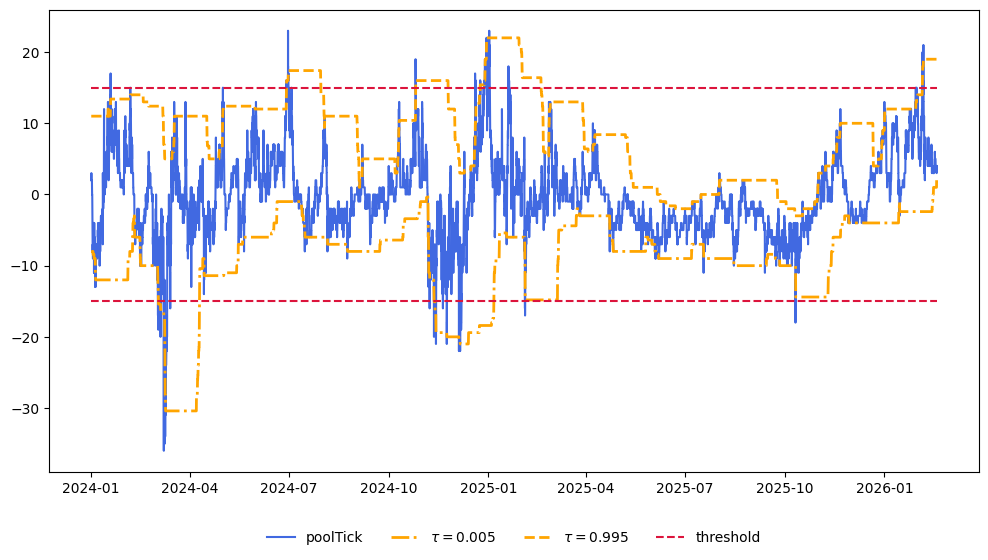

In [35]:
plt.figure(figsize=(12, 6))
ds = dataset[dataset.index > datetime.datetime(2024, 1, 1, tzinfo=datetime.timezone.utc)]
plt.plot(ds.index, ds["poolTick"], label="poolTick", color = "royalblue")
plt.plot(ds.index, th_d[ds.index], label=r"$\tau = 0.005$", color = "orange", linestyle="dashdot",  lw = 2)
plt.plot(ds.index, th_u[ds.index], label=r"$\tau = 0.995$", color = "orange", linestyle="dashed", lw = 2)
plt.hlines(y = - 15, xmin = ds.index[0], xmax = ds.index[-1], colors = "crimson", linestyles = "dashed", label = "threshold")
plt.hlines(y =  15, xmin = ds.index[0], xmax = ds.index[-1], colors = "crimson", linestyles = "dashed")
plt.legend(ncols = 4, bbox_to_anchor=(0.5, -0.1), loc="upper center", frameon = False)
plt.savefig('figs/dynamic_threshold.png', dpi = 300, bbox_inches = "tight", transparent = True)

In [ ]:
plt.plot(ds.index, ds[''])

In [4]:
TIME_COL = "timestamp"   
TARGET_COL = "target"    
df = dataset.copy()


df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df.sort_values(TIME_COL).reset_index(drop=True)


FEATURES = [c for c in df.columns if c not in [TIME_COL, TARGET_COL]]

X = df[FEATURES]
y = df[TARGET_COL].astype(int)

n = len(df)
test_size = int(0.30 * n)
val_size  = int(0.15 * n)

train_end = n - test_size
val_end = train_end
train_end2 = train_end - val_size

X_train, y_train = X.iloc[:train_end2], y.iloc[:train_end2]
X_val,   y_val   = X.iloc[train_end2:val_end], y.iloc[train_end2:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

num_cols = X_train.columns  # assuming all features are numeric
# If only some numeric:
num_cols = X_train.select_dtypes(include=np.number).columns

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols]   = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
y_train, y_val, y_test = y_train.values, y_val.values, y_test.values
# n_pos = (y_train == 1).sum()
# n_neg = (y_train == 0).sum()
# w_pos = (n_neg / max(n_pos, 1))

# w_train = np.where(y_train.values == 1, w_pos, 1.0)
# w_val   = np.where(y_val.values   == 1, w_pos, 1.0)
# w_test  = np.where(y_test.values  == 1, w_pos, 1.0)  # only used if you want weighted metrics

# print(f"Train positives={n_pos}, negatives={n_neg}, w_pos={w_pos:.3f}")



In [5]:
bal = (len(y)-sum(y))/sum(y)

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=bal,      
    random_state=1233,
    early_stopping_rounds=200
)

model.fit(
    X_train, y_train,    
    eval_set=[(X_train, y_train),(X_val, y_val)],
)

print("Best iteration:", model.best_iteration)

[0]	validation_0-auc:0.98313	validation_1-auc:0.71002
[1]	validation_0-auc:0.98927	validation_1-auc:0.69470
[2]	validation_0-auc:0.99471	validation_1-auc:0.58607
[3]	validation_0-auc:0.99663	validation_1-auc:0.60239
[4]	validation_0-auc:0.99726	validation_1-auc:0.63858
[5]	validation_0-auc:0.99742	validation_1-auc:0.63976
[6]	validation_0-auc:0.99761	validation_1-auc:0.66202
[7]	validation_0-auc:0.99765	validation_1-auc:0.63247
[8]	validation_0-auc:0.99772	validation_1-auc:0.64642
[9]	validation_0-auc:0.99817	validation_1-auc:0.65637
[10]	validation_0-auc:0.99817	validation_1-auc:0.65650
[11]	validation_0-auc:0.99814	validation_1-auc:0.65726
[12]	validation_0-auc:0.99808	validation_1-auc:0.65155
[13]	validation_0-auc:0.99801	validation_1-auc:0.64128
[14]	validation_0-auc:0.99796	validation_1-auc:0.63735
[15]	validation_0-auc:0.99799	validation_1-auc:0.63877
[16]	validation_0-auc:0.99798	validation_1-auc:0.63621
[17]	validation_0-auc:0.99794	validation_1-auc:0.63331
[18]	validation_0-au


=== Test Metrics ===
ROC AUC : 0.7360
AUPRC   : 0.1067

Confusion matrix (threshold = 0.50):
[[10272    37]
 [  536     6]]

Classification report:
               precision    recall  f1-score   support

           0     0.9504    0.9964    0.9729     10309
           1     0.1395    0.0111    0.0205       542

    accuracy                         0.9472     10851
   macro avg     0.5450    0.5037    0.4967     10851
weighted avg     0.9099    0.9472    0.9253     10851

Best threshold by Youden's J: 0.106 (TPR=0.821, FPR=0.409)


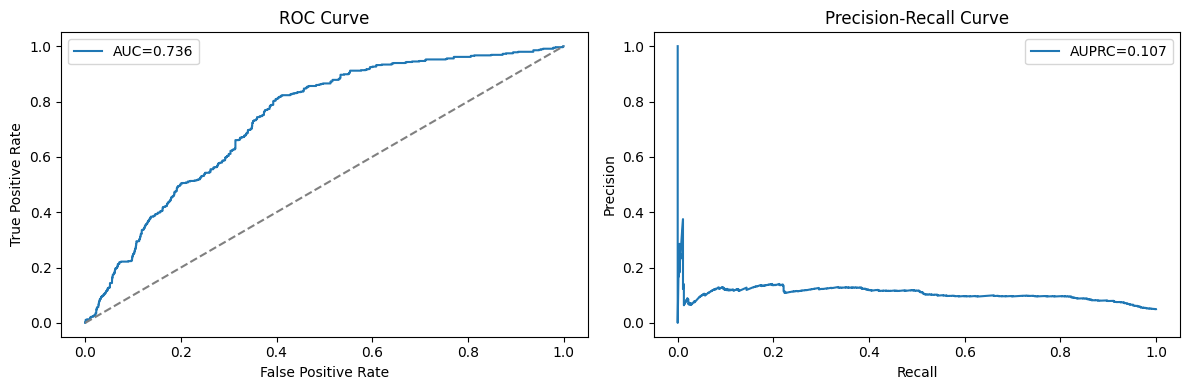

In [6]:
proba_test = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba_test)
auprc = average_precision_score(y_test, proba_test)

print("\n=== Test Metrics ===")
print(f"ROC AUC : {auc:.4f}")
print(f"AUPRC   : {auprc:.4f}")

# Pick a threshold (0.5 default). Often for imbalance you may tune it.
threshold = 0.50
yhat_test = (proba_test >= threshold).astype(int)

cm = confusion_matrix(y_test, yhat_test)
print("\nConfusion matrix (threshold = %.2f):\n%s" % (threshold, cm))
print("\nClassification report:\n", classification_report(y_test, yhat_test, digits=4))

# Plot ROC + PR curves
fpr, tpr, thresholds = roc_curve(y_test, proba_test)
prec, rec, _ = precision_recall_curve(y_test, proba_test)
j = tpr - fpr
best_idx = np.argmax(j)
thresh = thresholds[best_idx]
print(f"Best threshold by Youden's J: {thresh:.3f} (TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f})")
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
ax[0].plot([0, 1], [0, 1], "--", color="gray")
ax[0].set_title("ROC Curve")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()

ax[1].plot(rec, prec, label=f"AUPRC={auprc:.3f}")
ax[1].set_title("Precision-Recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.tight_layout()
plt.show()

In [7]:
X_explain = X_test.copy()
# if len(X_explain) > 5000:
#     X_explain = X_explain.sample(5000, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_explain)  # shap.Explanation

# Global importance (beeswarm)
# shap.plots.bar(shap_values, max_display=25)

In [58]:
inds = shap.utils.potential_interactions(shap_values[:,'curve_entropy'], shap_values)

In [59]:
inds

array([22, 28, 27, 30,  6, 14, 15, 92, 94, 95, 93, 96, 97, 98, 99, 29, 10,
       21, 32, 40,  8, 65,  7, 89, 43, 71, 34, 23, 47, 41, 12, 17, 39, 91,
       86,  0,  9, 25, 31, 18, 19, 50, 76, 79, 51, 52, 67, 37, 90, 80, 70,
       38, 73, 36, 83, 24, 49, 82, 77, 48,  3, 45, 44, 46, 42, 68, 35, 33,
       74, 88, 85,  1, 13, 26, 20,  2,  5,  4, 56, 62, 58, 11, 84, 78, 72,
       55, 66, 57, 59, 53, 60, 61, 75, 64, 63, 54, 69, 81, 87, 16])

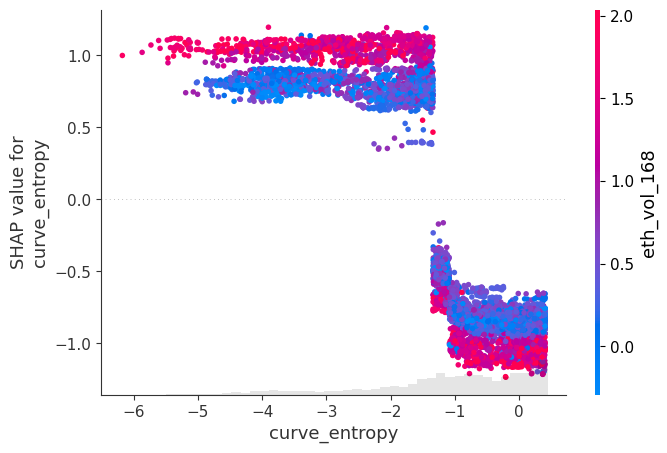

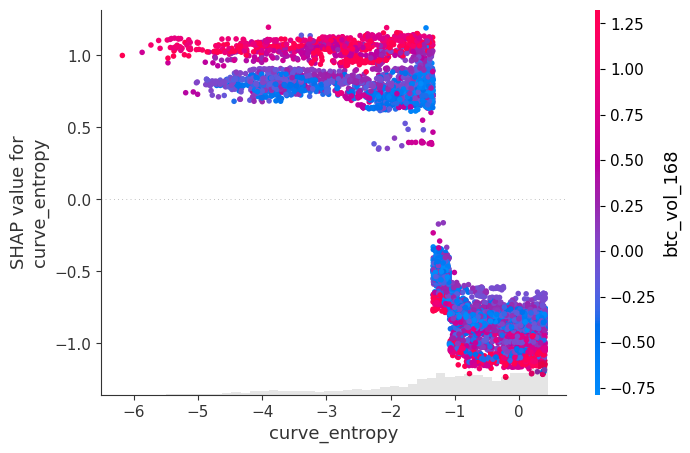

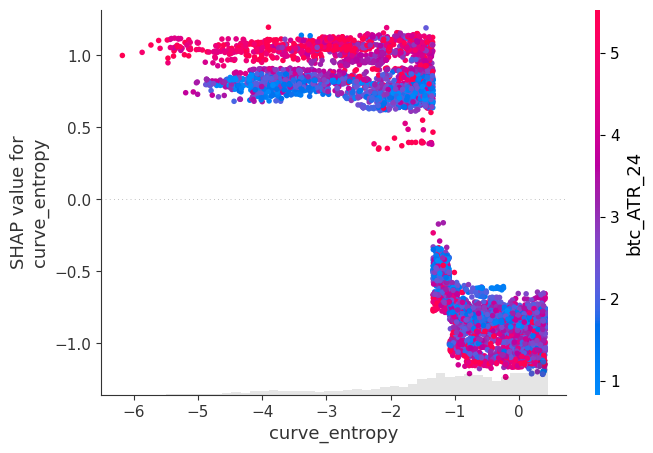

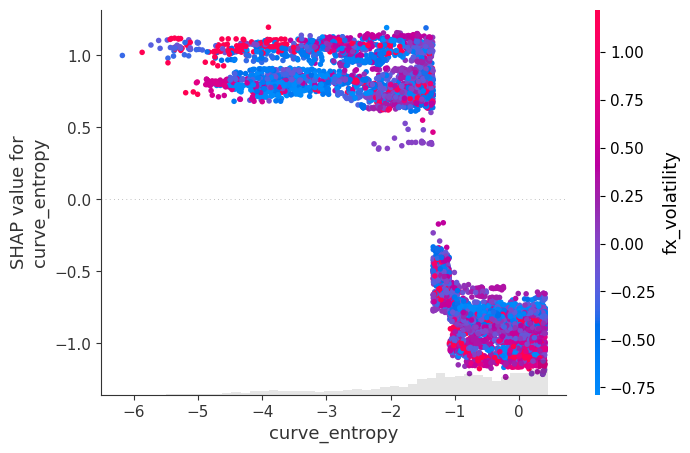

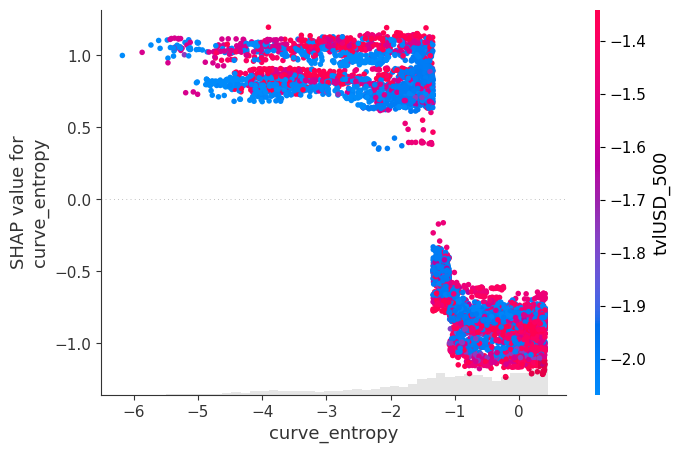

In [61]:
for i in range(5):
    shap.plots.scatter(shap_values[:, "curve_entropy"], color=shap_values[:, inds[i]])

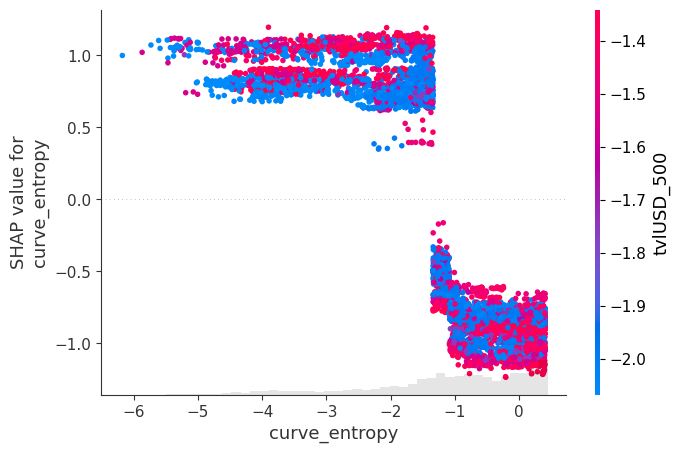

In [44]:
shap.plots.scatter(shap_values[:,'curve_entropy'], color = shap_values[:,'tvlUSD_500'])

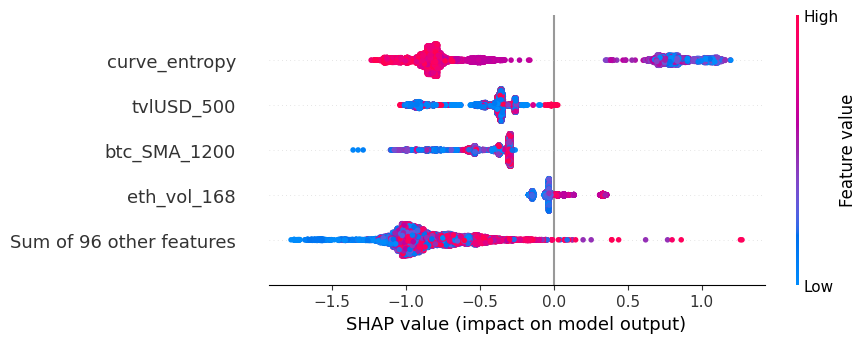

In [8]:
shap.plots.beeswarm(shap_values, max_display=5, order = np.argsort(shap_values.values.std(0))[::-1])


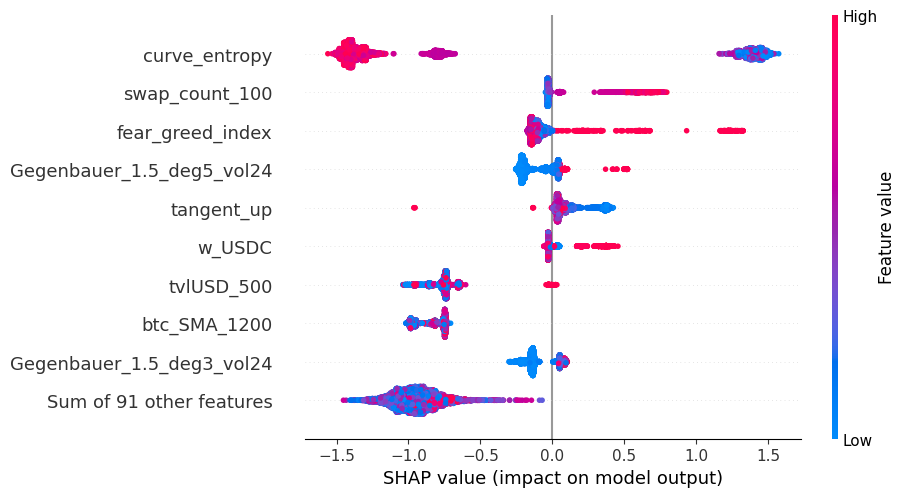

In [33]:
main_shap = np.diagonal(interactions, axis1=1, axis2=2)

exp = shap.Explanation(
    values=main_shap,
    data=X_test.values ,
    feature_names=list(X_test.columns),
)
shap.plots.beeswarm(exp, order = np.argsort(main_shap.std(0))[::-1])

In [46]:
import numpy as np

def top_interaction_pairs(interactions, feature_names=None, top_k=10):
    # interactions: (n_samples, n_features, n_features)
    n_feat = interactions.shape[1]
    iu = np.triu_indices(n_feat, k=1)  # upper triangle, exclude diagonal

    # strength per pair = mean(|interaction|) over samples
    strengths = np.mean((interactions[:, iu[0], iu[1]]), axis=0)

    order = np.argsort(strengths)[::-1][:top_k]
    pairs = list(zip(iu[0][order], iu[1][order], strengths[order]))

    if feature_names is None:
        return pairs
    return [(feature_names[i], feature_names[j], s) for i, j, s in pairs]

# usage
feature_names = list(X_test.columns) if hasattr(X_test, "columns") else None
pairs = top_interaction_pairs(interactions, feature_names, top_k=10)
pairs

[('tvlUSD_500', 'btc_SMA_1200', np.float32(0.18353662)),
 ('tvlUSD_500', 'curve_entropy', np.float32(0.082755856)),
 ('btc_SMA_1200', 'Gegenbauer_1.5_deg3_vol24', np.float32(0.057581447)),
 ('curve_entropy', 'btc_SMA_1200', np.float32(0.049939964)),
 ('btc_SMA_1200', 'btc_vol_168', np.float32(0.0457873)),
 ('tvlUSD_500', 'btc_EMA_4800', np.float32(0.034923155)),
 ('btc_EMA_4800', 'btc_vol_168', np.float32(0.03389786)),
 ('btc_EMA_4800', 'Gegenbauer_1.5_deg6_MA24', np.float32(0.02893272)),
 ('btc_EMA_4800', 'fear_greed_index', np.float32(0.027801443)),
 ('btc_SMA_1200', 'btc_EMA_4800', np.float32(0.01794431))]

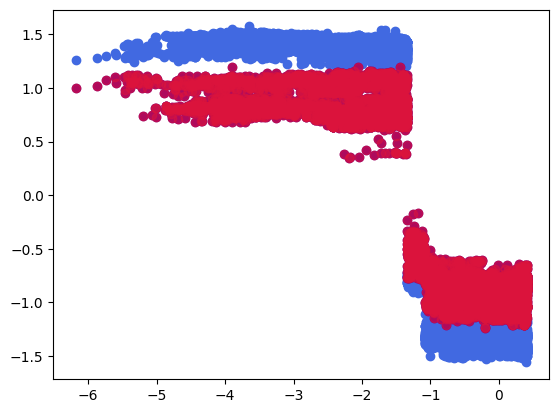

In [28]:
plt.scatter(X_test.iloc[:,16], interactions[:, 16,16], color = 'royalblue')
plt.scatter(X_test.iloc[:,16], np.sum(interactions[:, 16,:], axis = -1), color = 'purple')
plt.scatter(X_test.iloc[:,16], shap_values.values[:,16], alpha = 0.5, color = 'crimson')

In [ ]:
from treehfd import XGBTreeHFD

In [193]:
treehfd_model = XGBTreeHFD(model)
treehfd_model.fit(X_train, interaction_order = 2)


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


In [194]:
y_main, y_order2 = treehfd_model.predict(X_test)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


In [195]:
FEATURES = X.columns

In [196]:
np.argsort(np.abs(y_main).mean(axis=0))[::-1]

array([16, 25, 23,  6, 37,  9, 91, 18, 38,  3, 48, 14, 80, 17, 31, 28, 76,
       27, 65, 83, 45, 82, 10, 32,  7, 24, 46, 74, 21, 20, 47, 15, 96, 68,
       70, 71, 34, 29, 41, 51, 42, 94, 30, 86,  0, 95, 36, 39, 22, 49, 67,
       92, 40, 12, 93, 44, 73, 19, 26, 52, 88, 99,  8, 79,  4, 98, 90, 50,
       35, 85, 33, 13, 61, 63, 69, 72, 89, 87, 84, 97, 77, 78, 75, 81, 64,
       66, 43, 57, 60, 53, 55, 62, 56, 54, 58, 59, 11,  5,  2,  1])

In [197]:
X_test = X.iloc[val_end:].values

In [198]:
sv = shap_values.values

In [199]:
inter = treehfd_model.interaction_list

In [200]:
filtered_inter = [i for i,pair in enumerate(inter) if 16 in pair[:2]]
mask = np.array(filtered_inter)

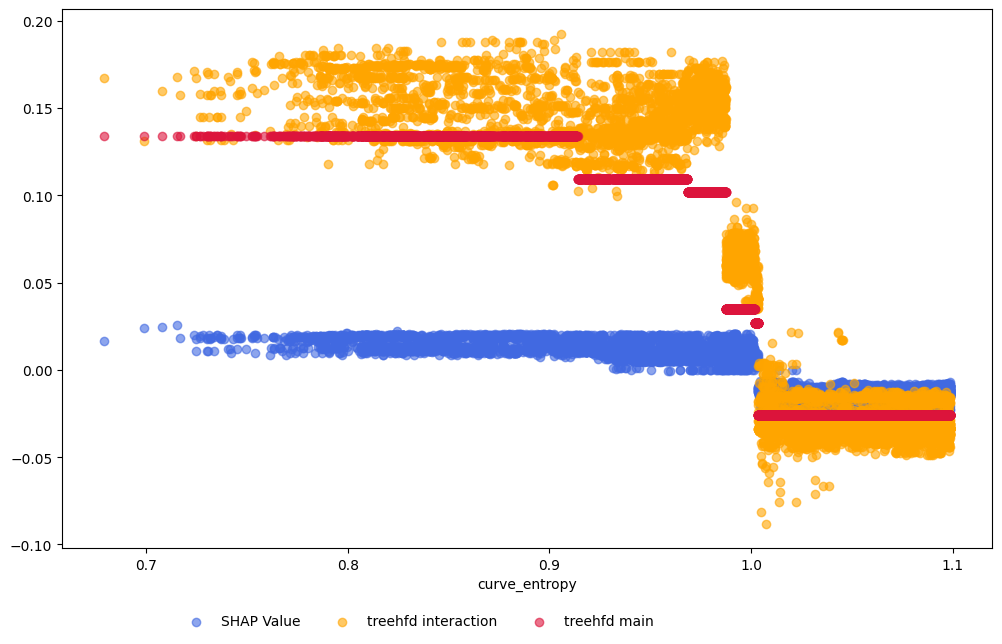

In [209]:
filtered_inter = [i for i,pair in enumerate(inter) if 16 in pair[1:2]]
mask = np.array(filtered_inter)
plt.figure(figsize=(12,7))
plt.scatter(X_test[:,16], sv[:,16], color = 'royalblue', label='SHAP Value', alpha= 0.6)
plt.scatter(X_test[:,16], y_main[:,16] + np.sum(y_order2[:,mask], axis=1), color = 'orange', label = 'treehfd interaction', alpha= 0.6)
plt.scatter(X_test[:,16], y_main[:,16], color = 'crimson', label = 'treehfd main', alpha = 0.6)
plt.xlabel(f'{FEATURES[16]}')
plt.legend(bbox_to_anchor=(.65, -0.1), frameon = False, ncols = 3)

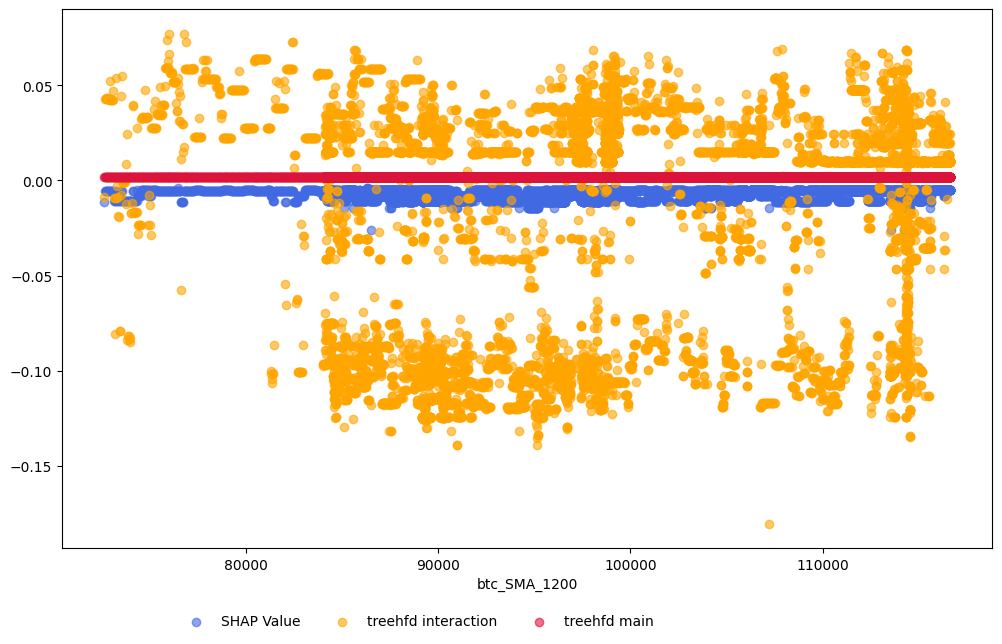

In [211]:
filtered_inter = [i for i,pair in enumerate(inter) if 24 in pair[1:2]]
mask = np.array(filtered_inter)
plt.figure(figsize=(12,7))
plt.scatter(X_test[:,24], sv[:,24], color = 'royalblue', label='SHAP Value', alpha= 0.6)
plt.scatter(X_test[:,24], y_main[:,24] + np.sum(y_order2[:,mask], axis=1), color = 'orange', label = 'treehfd interaction', alpha= 0.6)
plt.scatter(X_test[:,24], y_main[:,24], color = 'crimson', label = 'treehfd main', alpha = 0.6)
plt.xlabel(f'{FEATURES[24]}')
plt.legend(bbox_to_anchor=(.65, -0.1), frameon = False, ncols = 3)

In [177]:
hfd_pred = (treehfd_model.eta0 + np.sum(y_main, axis=1)
                + np.sum(y_order2, axis=1))
resid = proba_test - hfd_pred
mse_resid = np.round(np.mean(resid**2) / np.var(proba_test), decimals=3)
print(f"Normalized MSE of TreeHFD residuals: {mse_resid}")

Normalized MSE of TreeHFD residuals: 422.654


In [49]:
y_order2

array([[ 1.64081574e-04, -5.58939494e-05, -2.56694992e-03, ...,
        -8.59356852e-08,  8.25186480e-06, -1.37671904e-07],
       [ 1.64081574e-04, -9.06400915e-05, -1.86565386e-03, ...,
        -8.59356852e-08,  3.40959216e-06, -1.37671904e-07],
       [ 1.64081574e-04, -2.12664546e-04, -2.56694992e-03, ...,
        -8.59356852e-08,  3.40959216e-06, -1.37671904e-07],
       ...,
       [-6.04828473e-04, -3.77154738e-04, -3.94270352e-03, ...,
         4.45082348e-06, -1.17427668e-06,  1.71246767e-06],
       [-6.04828473e-04, -3.77154738e-04, -3.94270352e-03, ...,
         4.45082348e-06, -1.17427668e-06,  1.71246767e-06],
       [-6.04828473e-04, -3.77154738e-04, -3.64741417e-03, ...,
         4.45082348e-06, -1.17427668e-06,  1.71246767e-06]],
      shape=(10851, 4762))

Text(0.5, 0, 'E_low_logret')

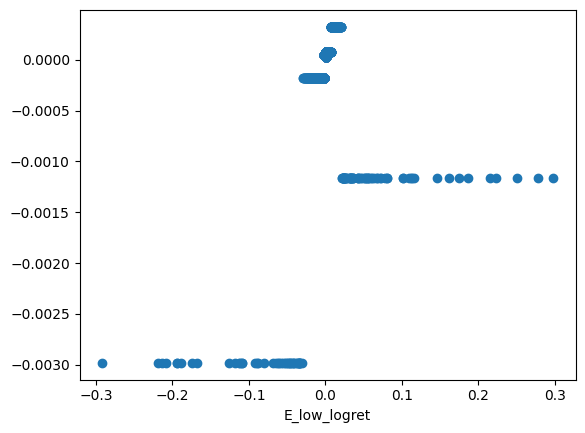

In [47]:
plt.scatter(X_test[:,59], y_main[:,59])
plt.xlabel(f'{FEATURES[59]}')

Text(0.5, 0, 'mid_ratio_logret')

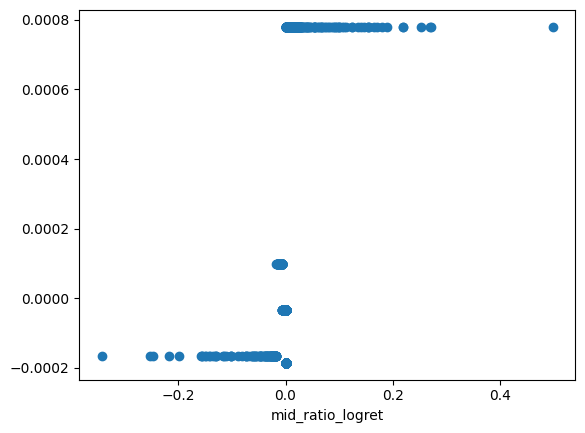

In [48]:
plt.scatter(X_test[:,63], y_main[:,63])
plt.xlabel(f'{FEATURES[63]}')

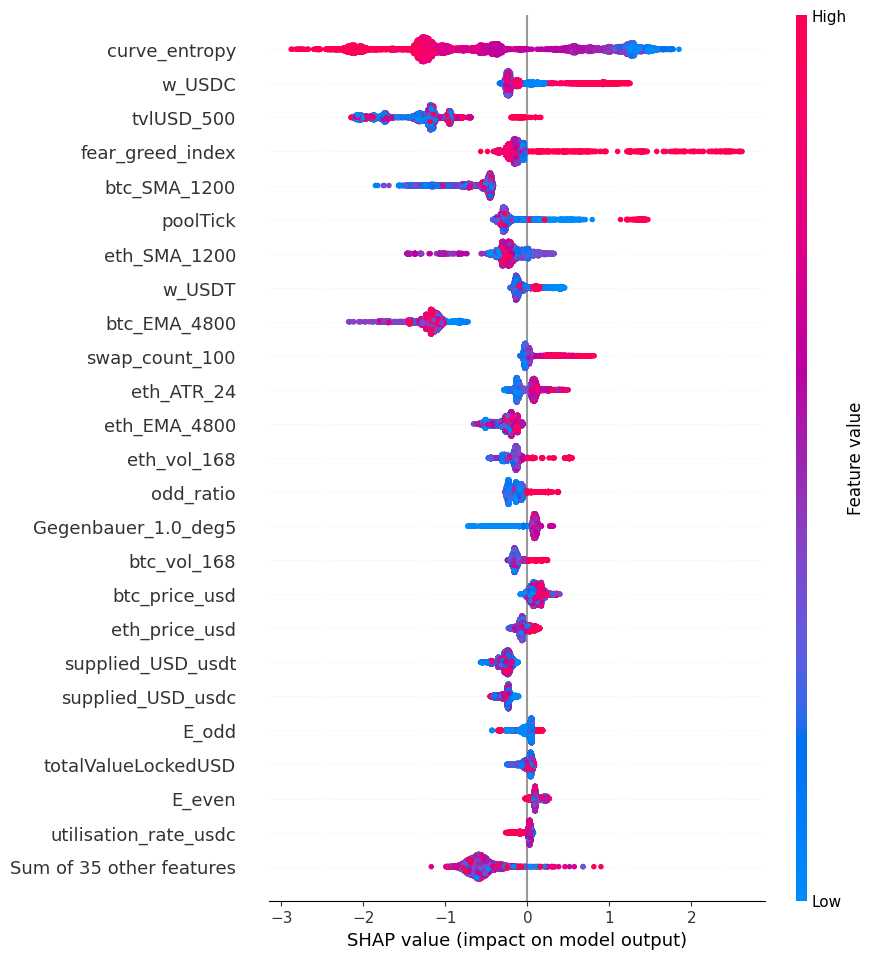

In [122]:
std_per_feature = shap_values.values.std(axis=0)          
order = np.argsort(std_per_feature)[::-1]   
shap.plots.beeswarm(shap_values, order=order, max_display=25)

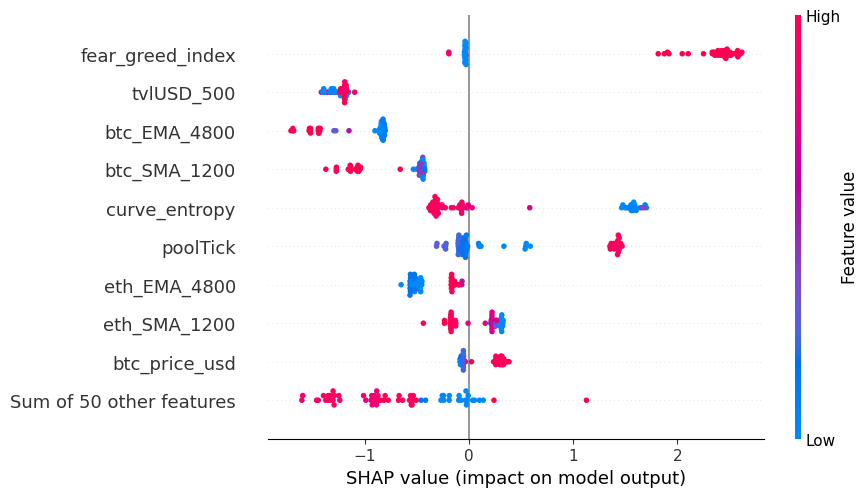

In [138]:
warn_mask = proba_test >= 0.2

sv_warn = shap_values[warn_mask]   

shap.plots.beeswarm(sv_warn)

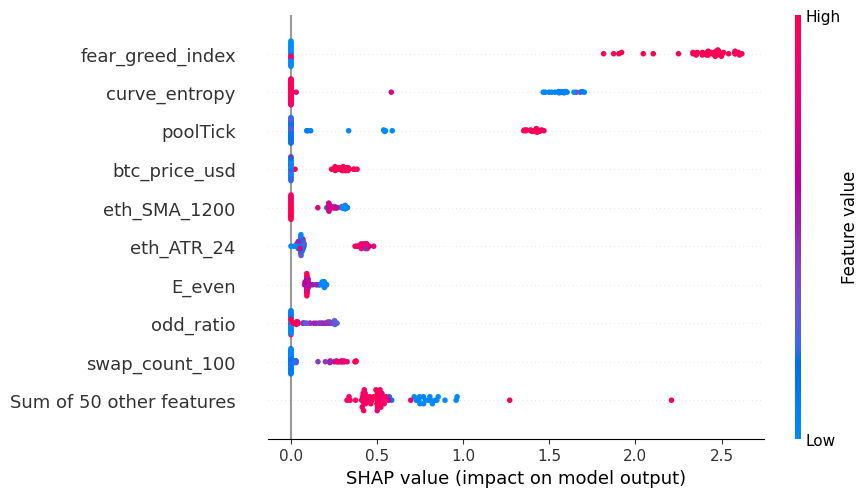

In [139]:
pos_mean = np.clip(sv_warn.values, 0, None).mean(axis=0)
order = np.argsort(pos_mean)[::-1]

shap.plots.beeswarm(sv_warn_pos, order=order)

In [2]:
shap.plots.bar(, order=order)

NameError: name 'sv_warn_pos' is not defined

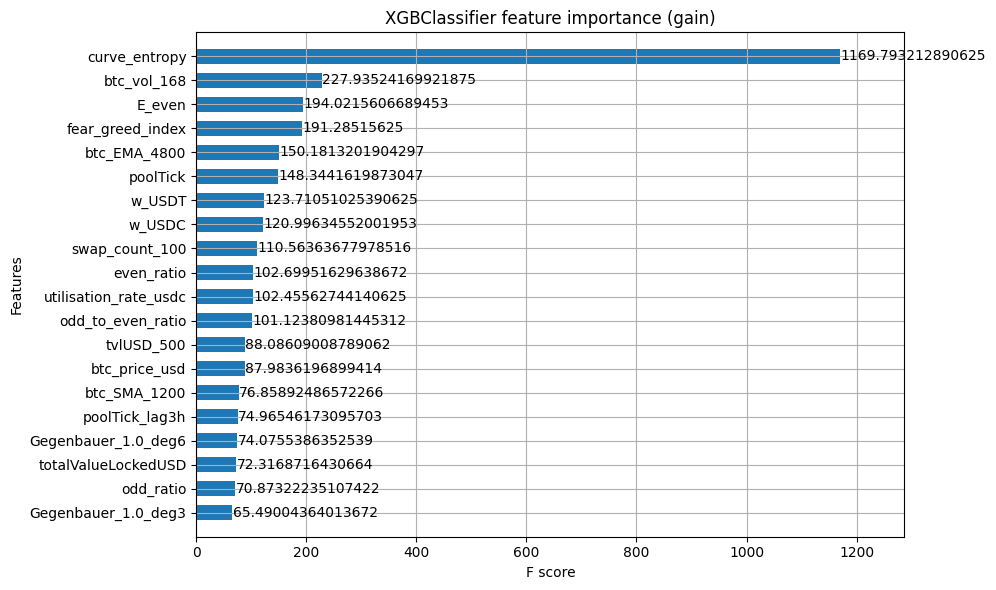

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="gain",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (gain)")
plt.tight_layout()
plt.show()

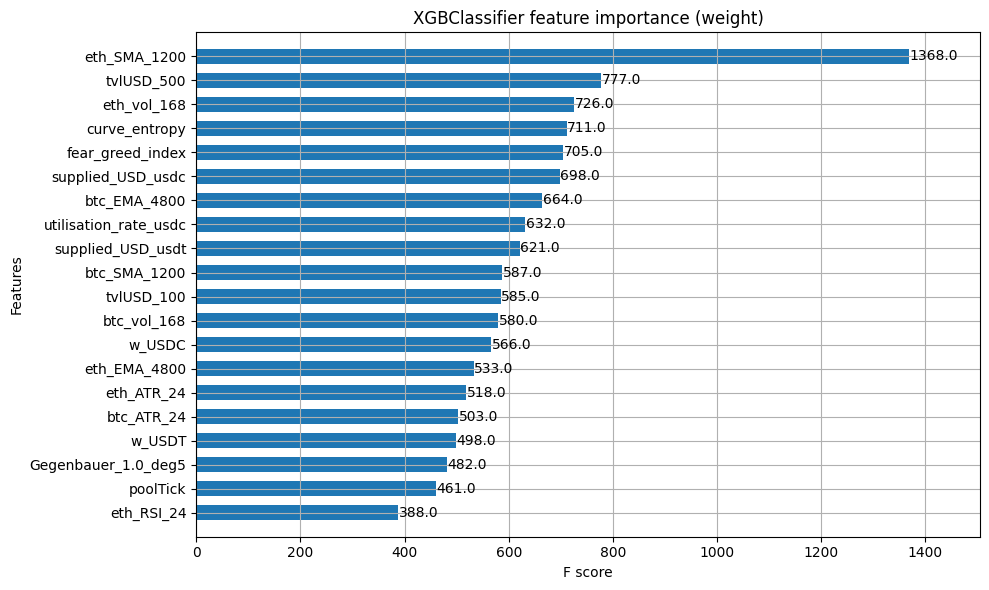

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="weight",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (weight)")
plt.tight_layout()
plt.show()

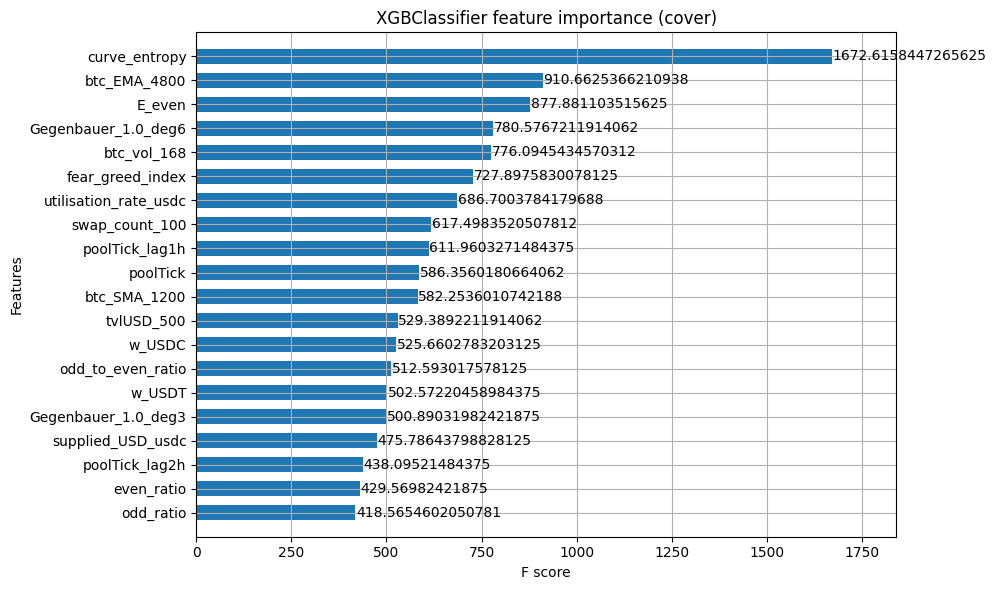

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="cover",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (cover)")
plt.tight_layout()
plt.show()

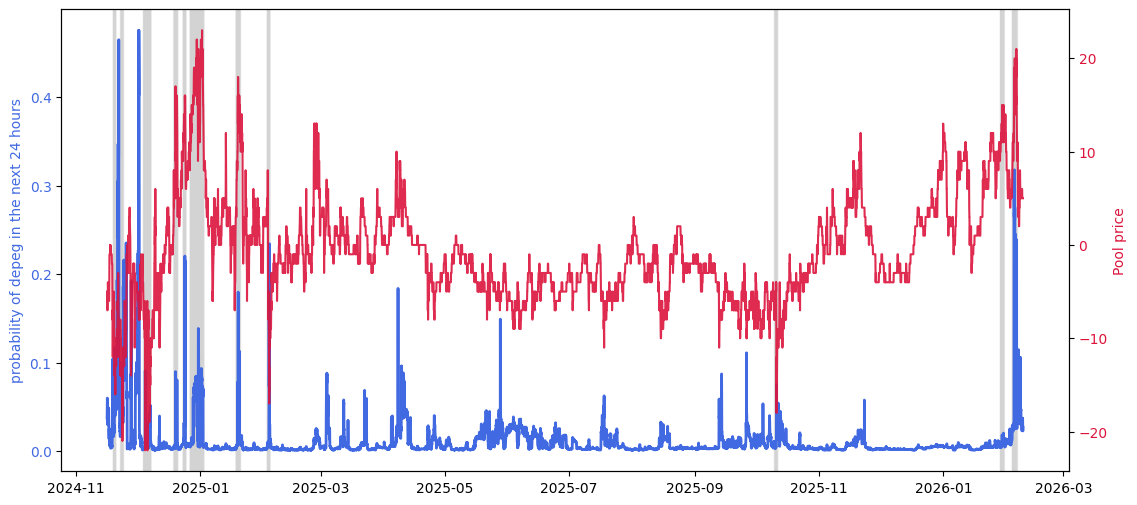

In [90]:
test_dates = df['timestamp'].iloc[val_end:]
fig, ax = plt.subplots(figsize=(13,6))
axi = ax.twinx()

# Fill vertically in red wherever y_test = 1
y_test_reset = y_test.reset_index(drop=True)
for i in range(len(y_test_reset)):
    if y_test_reset.iloc[i] == 1:
        ax.axvspan(test_dates.iloc[i], test_dates.iloc[min(i+1, len(test_dates)-1)], 
                   color='lightgrey', alpha=0.2, zorder=0)

ax.plot(test_dates, proba_test, label="Predicted Probability", color="royalblue", lw =2, zorder=2)
axi.plot(test_dates, X_test['poolTick'].reset_index(drop=True), label="Pool price", color = 'crimson', lw=1.5, alpha = 0.9, zorder =1)
# axi.plot(test_dates,y_test, label="Pool price", color = 'crimson', lw=1.5)
ax.set_ylabel("probability of depeg in the next 24 hours", color='royalblue')
axi.set_ylabel("Pool price", color='crimson')
ax.tick_params(axis='y', labelcolor='royalblue')
axi.tick_params(axis='y', labelcolor='crimson')
plt.savefig('./figs/predictions_over_time.png', dpi=300, transparent = True, bbox_inches='tight')

In [92]:
usdt = pd.read_parquet('./data/AAVE/aave_v3_usdt_eth.parquet')['lender_variable_apr']
usdc = pd.read_parquet('./data/AAVE/aave_v3_usdc_eth.parquet')['lender_variable_apr']

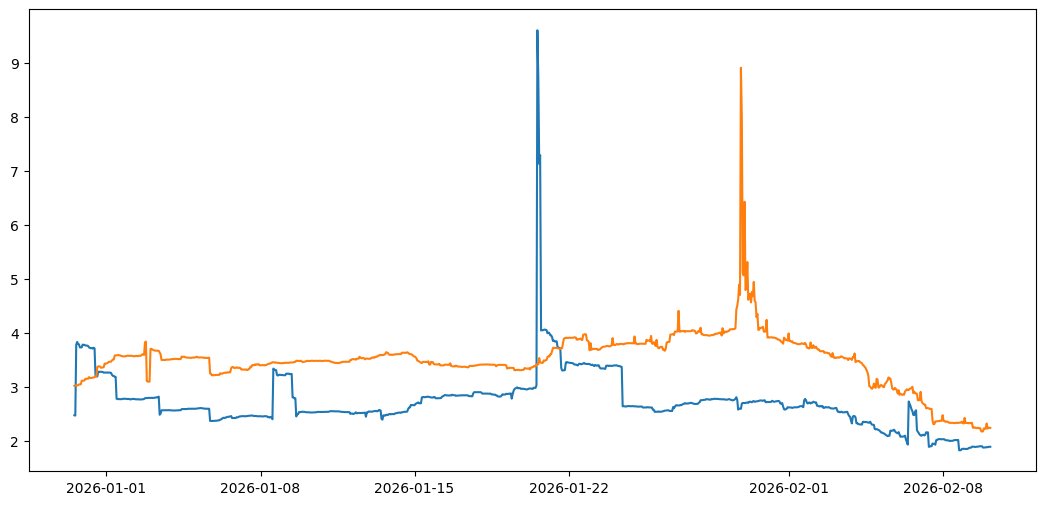

In [96]:
fig, ax = plt.subplots(figsize=(13,6))
plt.plot(usdt.iloc[-1000:])
plt.plot(usdc.iloc[-1000:])

'/home/jovyan/cloned_gits/stablecoin-depeg-forecast/artifacts/3197/xgboost_alpha_1.5_fullfeatures/'